In [11]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20,10

# Feature Importance Analysis
## P-Value Caveats Demonstrations
P-Values has the following pitfalls:
- Rely on many strong assumptions
- Produces noisy estimates
- Is a probability of something we don't need: Given $H_0$ and an estimated $\hat{\beta}$, p-values
estimates the probability of obtaining a result equal or more extreme than $\hat{\beta}$, subject to $H_0$ being true.
We are more interested in the probability of $H_0$ being true given an observed $\hat{\beta}$
- Not generalizable out of sample

In [12]:
from sklearn.datasets import make_classification

def get_test_data(n_features=100, n_informative=25, n_redundant=25,
                  n_samples = 10000, random_state = 0, sigma_std = .0):
    """
    Generates a random set of informed, redundant and noise explanatory variables
    :param n_features: Total number of features
    :type n_features: int
    :param n_informative: Number of informative features (subset of the features)
    :type n_informative: int
    :param n_redundant: Number of redundant features (subset of features)
    :type n_redundant: int
    :param n_samples: samples number
    :type n_samples: int
    :param random_state: random state
    :type random_state: float
    :param sigma_std: standard deviation
    :type sigma_std: float
    :return:  X : Dataframe of the generated samples.
              y : Series of the integer labels for class membership of each sample.
    :rtype: (pd.DataFrame, pd.Series)
    """
    np.random.seed(random_state)

    # Generate a random n-class classification problem
    X,y = make_classification(
        n_samples=n_samples, n_features=n_features-n_redundant, n_informative=n_informative,
        n_redundant=0, shuffle=False, random_state=random_state
    )

    # Rename the columns
    cols = [f'I_{i}' for i in range(n_informative)]
    cols += [f'N_{i}' for i in range(n_features - n_informative - n_redundant)]
    X = pd.DataFrame(X, columns=cols)
    y = pd.Series(y)

    # Create the redundant features
    i = np.random.choice(range(n_informative), size=n_redundant)
    for k, j in enumerate(i):
        X[f'R_{k}'] = X[f'I_{j}'] + np.random.normal(size=X.shape[0]) * sigma_std

    return X,y

In [13]:
import statsmodels.discrete.discrete_model as sm

X, y = get_test_data(
    n_features=40, n_informative=5, n_redundant=30, n_samples=10000,
    sigma_std=0.1
)

ols = sm.Logit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


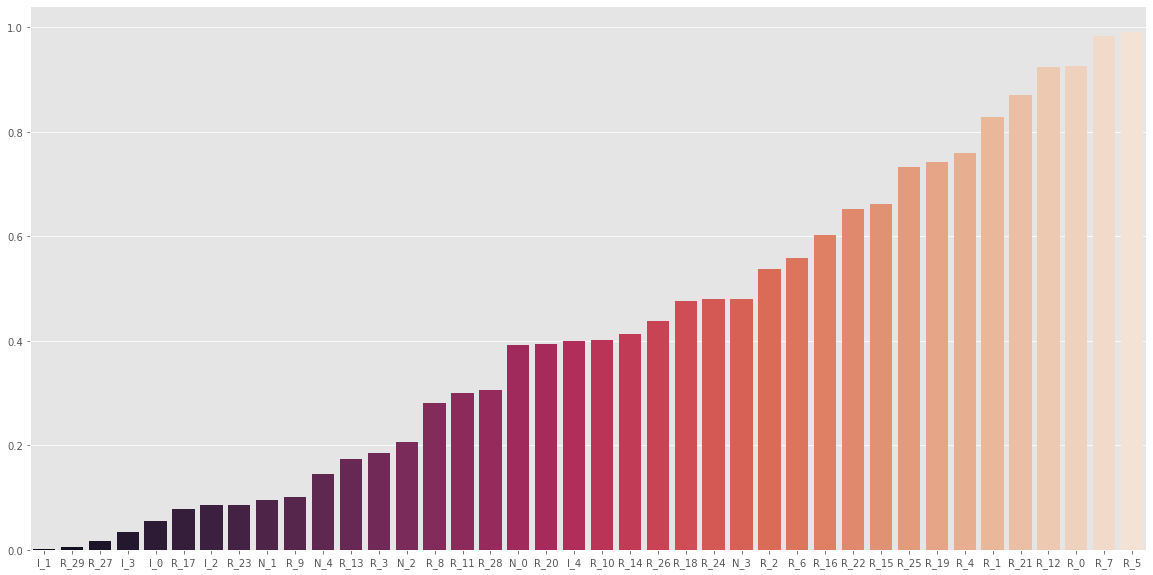

In [14]:
# Generate some sequential data
pvalues_sorted = ols.pvalues.sort_values()
sns.barplot(x=pvalues_sorted.index, y=pvalues_sorted.values, palette="rocket")

- Only four out of the thirty five non-noise features are deemed statistically significant : I_1, R_29, R_27, I_3.
- Noise features are ranked as relatively important
- Fourteen of the features ranked as least important are not noise

## Mean-Decrease Impurity

In [15]:
def feat_imp_mdi(clf, feat_names):
    """
    Feature importance beased on IS mean impurity reduction
    :param clf: a built estimator using an ensemble method
    :type clf: e.g BaggingClassifier
    :param feat_names: The features names
    :type feat_names: Array like
    :return: An importance dataframe with the index as the column names and mean / std as the columns
    :rtype: pd.DataFrame
    """
    # Loop through all the estimators (DecisionTreeClassifier) and get the feature importance array
    # (Gini Importance)
    df0 = {
        i: tree.feature_importances_ for i, tree in enumerate(clf.estimators_)
    }
    df0 = pd.DataFrame.from_dict(df0, orient="index")
    df0.columns = feat_names
    df0 = df0.replace(0, np.nan) # beacause max_features=1

    imp = pd.concat(
        {
            'mean': df0.mean(),
            'std': df0.std() * df0.shape[0]**-.5
        },
        axis=1
    )

    imp /= imp['mean'].sum()
    return imp

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

X, y = get_test_data(
    n_features=40, n_informative=5, n_redundant=30, n_samples=10000,
    sigma_std=0.1
)

clf = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    class_weight='balanced',
    min_weight_fraction_leaf=0
)

clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                        max_features=1., max_samples=1.)

clf_fit = clf.fit(X,y)

imp = feat_imp_mdi(clf=clf_fit, feat_names=X.columns).sort_values(by=['mean'])


<ErrorbarContainer object of 3 artists>

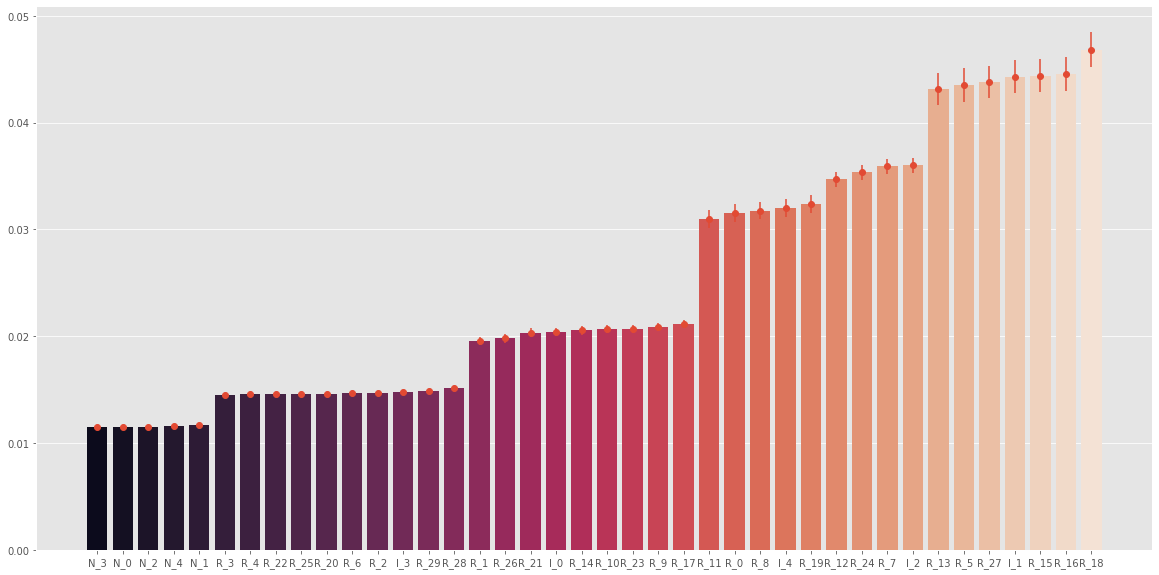

In [17]:
ax = sns.barplot(x=imp.index, y=imp['mean'].values, palette="rocket")
ax.errorbar(imp.index, imp['mean'], yerr=imp['std'], ls='none', fmt='-o')

- MDI does a good job as noisy features are less important
- A small number of nonnoisy features appear to be much more important than their peers (substitution effect)

Out of the 4 p-values pitfalls, the MDI method deals with three: 
- No need for strong distributional assumptions
- Variance of MDI estimates can be reduced by increasing the number of trees in ensemble methods in general or random forest in particular -> less noisy results 
- The goal of the the tree-based classifiers is not to estimate the coefficients of a given algebraic equation. Estimating the probability of $H_0$ is irrelevant. MDI looks for important features in general. 
- MDI doesn't fully solve the out of sample caveat encountered with p-values. 

## Mean-Decrease Accuracy

In [18]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

def feat_imp_mda(clf, X, y, n_splits=10):
    """
    Feature importance based on OOS score reduction
    :param clf: a classifier using an ensemble method
    :type clf: e.g BaggingClassifier
    :param X: The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
    :type X: {array-like, sparse matrix} of shape (n_samples, n_features)
    :param y: The target values (class labels in classification, real numbers in
            regression).
    :type y: array-like of shape (n_samples,)
    :param n_splits: Number of folds. Must be at least 2.
    :type n_splits: int
    :return: An importance dataframe with the index as the column names and mean / std as the columns
    :rtype: pd.DataFrame
    """
    # feat importance based on OOS score reduction
    cv_gen = KFold(n_splits=n_splits) 
    score_0, score_1 = pd.Series(), pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cv_gen.split(X=X)):
        X0, y0 = X.iloc[train,:], y.iloc[train]
        X1, y1 = X.iloc[test,:], y.iloc[test]
        fit = clf.fit(X=X0, y=y0) # the fit occurs here 
        prob = fit.predict_proba(X1) # prediction before shuffling 
        score_0.loc[i] = -log_loss(y1,prob, labels=clf.classes_)
        for j in X.columns:
            X1_ = X1.copy(deep=True) 
            np.random.shuffle(X1_[j].values) # shuffle one column 
            prob = fit.predict_proba(X1_) # prediction after shuffling 
            score_1.loc[i,j] = -log_loss(y1, prob, labels=clf.classes_)
    imp = (-1 * score_1).add(score_0, axis=0)
    imp = imp/(-1 * score_1)
    imp = pd.concat(
        {
            'mean':imp.mean(),
            'std':imp.std()*imp.shape[0]**-.5
        },
        axis=1
    ) # CLT 
    return imp

In [19]:
X, y = get_test_data(
    n_features=40, n_informative=5, n_redundant=30, n_samples=10000,
    sigma_std=0.1
)

clf = DecisionTreeClassifier(
    criterion='entropy', max_features=1,
    class_weight='balanced', min_weight_fraction_leaf=0
)
clf = BaggingClassifier(
    base_estimator=clf, n_estimators=1000, max_features=1., 
    max_samples=1., oob_score=False
) 

imp=feat_imp_mda(clf,X,y,10).sort_values(by=['mean'])

<ipython-input-18-d72ca5b175c5>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  score_0, score_1 = pd.Series(), pd.DataFrame(columns=X.columns)


<ErrorbarContainer object of 3 artists>

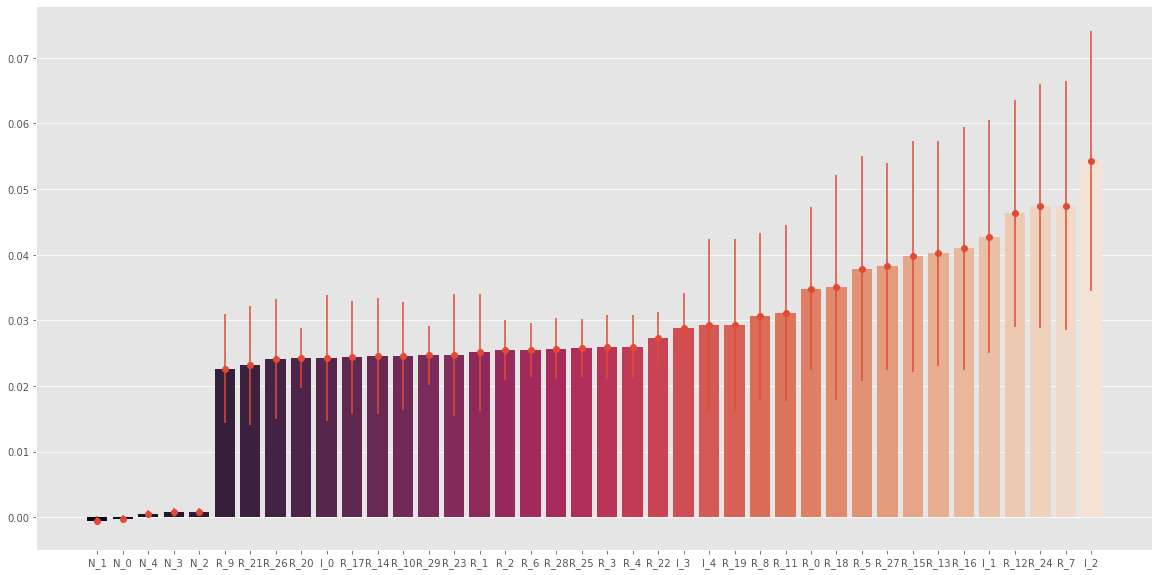

In [21]:
ax = sns.barplot(x=imp.index, y=imp['mean'].values, palette="rocket")
ax.errorbar(imp.index, imp['mean'], yerr=imp['std'], ls='none', fmt='-o')

- Noise features are ranked last 
- Noise features are also deemed unimportant in magnitude, with MDA values of essentially zero 

## Probability-Weighted Accuracy

#TODO: Implement the PWA

# Substitution Effects

## Orthogonalization

In [ ]:
#TODO: Implement orthogonalization example

## Cluster Feature Importance
1- Features clustering: after projecting the observed features into a metric space (correlation or other
non linear metrics), we perform a clustering. For each cluster k=1,...,K, we replace the features included
in the cluster with residual features, where those residual features do not contain information from features
outside the cluster k.
2- Cluster importance: We use the outcome from step 1 (clusters and features) to apply MDI or MDA on groups
of similar features rather on individual features.

In [ ]:
def group_mean_std(df0, clusters):
    out = pd.DataFrame(columns=['mean','std'])
    for i,j in clusters.items():
        df1 = df0[j].sum(axis=1)
        out.loc[f'C_{i}','mean'] = df1.mean()
        out.loc[f'C_{i}','std'] = df1.std()*df1.shape[0]**-.5
    return out

def feat_imp_mdi_clustered(fit, feat_names, clusters):
    df0 = {
        i:tree.feature_importances_
        for i,tree in enumerate(fit.estimators_)
    }
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = feat_names
    df0 = df0.replace(0,np.nan) # because max_features=1
    imp = group_mean_std(df0, clusters)
    imp /= imp['mean'].sum()
    return imp

In [ ]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

def feat_imp_mda_clustered(clf, X, y, clusters, n_splits=10):
    cv_gen = KFold(n_splits=n_splits)
    score_0, score_1 = pd.Series(),pd.DataFrame(columns=clusters.keys())
    for i, (train,test) in enumerate(cv_gen.split(X=X)):
        X0, y0 = X.iloc[train,:],y.iloc[train]
        X1, y1 = X.iloc[test,:],y.iloc[test]
        fit = clf.fit(X=X0, y=y0)
        prob = fit.predict_proba(X1)
        score_0.loc[i] = -log_loss(y1,prob,labels=clf.classes_)
        for j in score_1.columns:
            X1_ = X1.copy(deep=True)
            for k in clusters[j]:
                np.random.shuffle(X1_[k].values) # shuffle cluster
            prob = fit.predict_proba(X1_)
            score_1.loc[i,j] = -log_loss(y1, prob, labels=clf.classes_)
    imp = (-1 * score_1).add(score_0, axis=0)
    imp = imp/(-1 * score_1)
    imp = pd.concat(
        {
            'mean': imp.mean(),
            'std': imp.std()*imp.shape[0]**-.5
        },
        axis=1
    )
    imp.index=[f'C_{i}' for i in imp.index]
    return imp

## Experimental Results

In [ ]:
# Generate the test data and using KMeansBase for clustering
from src.cluster import KMeansBase

X, y = get_test_data(
    n_features=40, n_informative=5, n_redundant=30, n_samples=10000,
    sigma_std=0.1
)

clustering = KMeansBase(max_n_clusters=10, random_state=0).fit(X.corr())

In [ ]:
# Getting the clusters dictionary
clusters = {}
for i in clustering.labels_:
    clusters[i] = X.columns[np.where(clustering.labels_ == i)]

In [ ]:
# Get the sorted columns from KMeans
columns = [X.columns.tolist()[i] for i in np.argsort(clustering.labels_)]
X_sorted = X.reindex(columns, axis=1)

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(X_sorted.corr(), fignum=f.number)
plt.xticks(range(X_sorted.shape[1]), X_sorted.columns, fontsize=14, rotation=45)
plt.yticks(range(X_sorted.shape[1]), X_sorted.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix after KMeansBase', fontsize=16);

### Clustered MDI

In [ ]:
clf = DecisionTreeClassifier(
    criterion='entropy', max_features=1,
    class_weight='balanced', min_weight_fraction_leaf=0
)
clf = BaggingClassifier(
    base_estimator=clf, n_estimators=1000, max_features=1.,
    max_samples=1., oob_score=False
)
fit = clf.fit(X, y)

imp = feat_imp_mdi_clustered(fit=fit, feat_names=X.columns, clusters=clusters).sort_values(by=['mean'])

In [ ]:
ax = sns.barplot(x=imp.index, y=imp['mean'].values, palette="rocket")
ax.errorbar(imp.index, imp['mean'], yerr=imp['std'], ls='none', fmt='-o')

**Remarks**
- The last cluster C_1 is associated with the noise features and all other clusters are associated
with informative and redundant features
- In contrast with the result without clustering, some non-noise features appeared to be much more important
than others, even after taking into consideration the standard deviation around the mean values

### Clustered MDA

In [ ]:
clf = DecisionTreeClassifier(
    criterion='entropy', max_features=1,
    class_weight='balanced', min_weight_fraction_leaf=0
)
clf = BaggingClassifier(
    base_estimator=clf, n_estimators=1000, max_features=1.,
    max_samples=1., oob_score=False
)

imp = feat_imp_mda_clustered(clf=clf, X=X, y=y, clusters=clusters, n_splits=10).sort_values(by=['mean'])

In [ ]:
ax = sns.barplot(x=imp.index, y=imp['mean'].values, palette="rocket")
ax.errorbar(imp.index, imp['mean'], yerr=imp['std'], ls='none', fmt='-o')

**Remarks**
- The last cluster C_1 is associated with the noise features and has zero importance (noise)
- Same remarks as for the clustered MDI features importance review

# Conclusions
- Using p-values to evaluate the significance of explanatory variables has major flaws
- ML offers feature importance methods that overcome most or all of the p-values flaws
- MDI/MDA assess the importance of features robustly (without making strong assumptions on the distribution)
- The perception that ML tools are black-boxes and classical tools is false
- Important to consider carefully what are we interested in explaining or predicting.

# Exercises
**1-** Consider a medical test with a false positive rate $ \alpha = P[x>\tau|H_0]$
where H_0 is the null hypothesis (the patient is healthy),
$x$ is the observed measurement, and $\tau$ is the significance threshold.

A test is run on a random patient and comes back positive (the null hypothesis is rejected).

What is the probability that the patient truly has the condition?

**a.** Is it $1-\alpha = P[x≤\tau|H_0]$ (the confidence of the test) ?
No, because it stands for the probability to have negative test when the patient is healthy

**b.** Is it $1-\beta = P[x>\tau|H_1]$ (the power,or recall,of the test)?
No, because this measure stands for the probability to have a true positive.

**c.** Or is it $P[H_1|x>\tau]$ (the precision of the test)? Yes as the later stands for the probability that the
patient has the condition knowing that his test came back positive.

**d.** Of the above, what do p-values measure ? p-values is the lowest significance level on
which we can reject H0 (patient is healthy). If we compute the P-value p,
we reject on a significance level $\alpha$ if $p ≤ \alpha$

**e.** In finance,the analogous situation is to test whether a variable is involved
in a phenomenon. Do p-values tell us anything about the probability that
the variable is relevant, given the observed evidence? No as explained in cavet#3

**2-** Consider a medical test where $\alpha = 0.01$, $\beta = 0$, and the probability of the condition is
$P[H_1] = 0.001$. The test has full recall and a very high confidence.
What is the probability that a positive-tested patient is actually sick?

From Bayes' theorem:

$$\frac{P[H_1 | x > \tau]}{P[x > \tau | H_1]} = \frac{P[H_1]}{P[x > \tau]} $$

From the law of total probability:

$$P[H_1 | x > \tau] = \frac{P[H_1] \times P[x > \tau | H_1]}{P[x > \tau|H_0] \times P[H_0] + P[x > \tau|H_1] \times P[H_1]}$$

With $\beta = 0$

$$P[H_1 | x > \tau] = \frac{P[H_1]}{\alpha \times (1-P[H_1]) + P[H_1]}$$

In [5]:
p_h1= 0.001
alpha = 0.01
p_sick =  p_h1/(alpha*(1-p_h1)+p_h1)

The probability found is of 0.091 which means that we have a 10% chance that the patient is sick
if the test is positive.

Why is it much lower than $1 - \alpha$ and $1 - \beta$?

It is much lower because the probability that the test is positive is $P(x>\tau) = 0.01099$ due to a high positive rate ($\alpha$). Thus we need to test confidence.

What is the probability that a patient is actually sick after testing positive twice on independent tests?

We have :
$$\frac{P[H_1 | T_1 \cap T_2]}{P[ T_1 \cap T_2| H_1]} = \frac{P[H_1]}{P[T_1 \cap T_2]} $$

Which leads us to : (warning : recheck the calculation)

$$P[H_1 | T_1 \cap T_2] = \frac{P[H_1] \times P[ T_1 \cap T_2| H_1]}{P[ T_1] \times P[ T_2]} $$


**3-** Rerun the examples in Sections 6.3.1 and 6.3.2,where this time you pass an argument sigmaStd=0
to the getTestData function. How do Figures 6.2 and 6.3 look now?
What causes the difference, if there is one?

<ErrorbarContainer object of 3 artists>

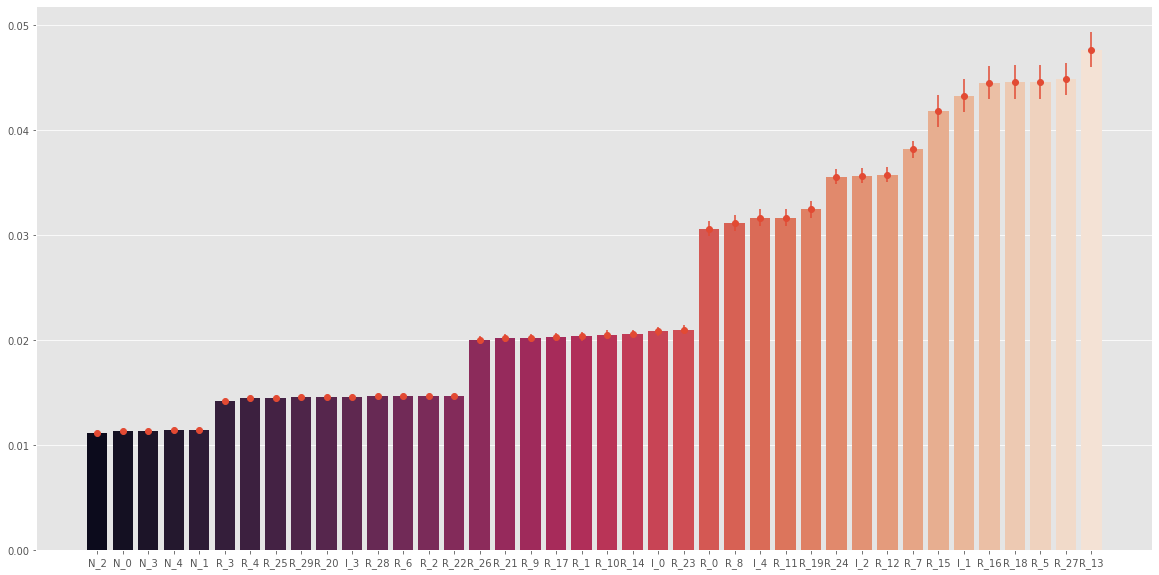

In [22]:
# MDI
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

X, y = get_test_data(
    n_features=40, n_informative=5, n_redundant=30, n_samples=10000
)

clf = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    class_weight='balanced',
    min_weight_fraction_leaf=0
)

clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                        max_features=1., max_samples=1.)

clf_fit = clf.fit(X,y)

imp = feat_imp_mdi(clf=clf_fit, feat_names=X.columns).sort_values(by=['mean'])

ax = sns.barplot(x=imp.index, y=imp['mean'].values, palette="rocket")
ax.errorbar(imp.index, imp['mean'], yerr=imp['std'], ls='none', fmt='-o')

<ipython-input-18-d72ca5b175c5>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  score_0, score_1 = pd.Series(), pd.DataFrame(columns=X.columns)


<ErrorbarContainer object of 3 artists>

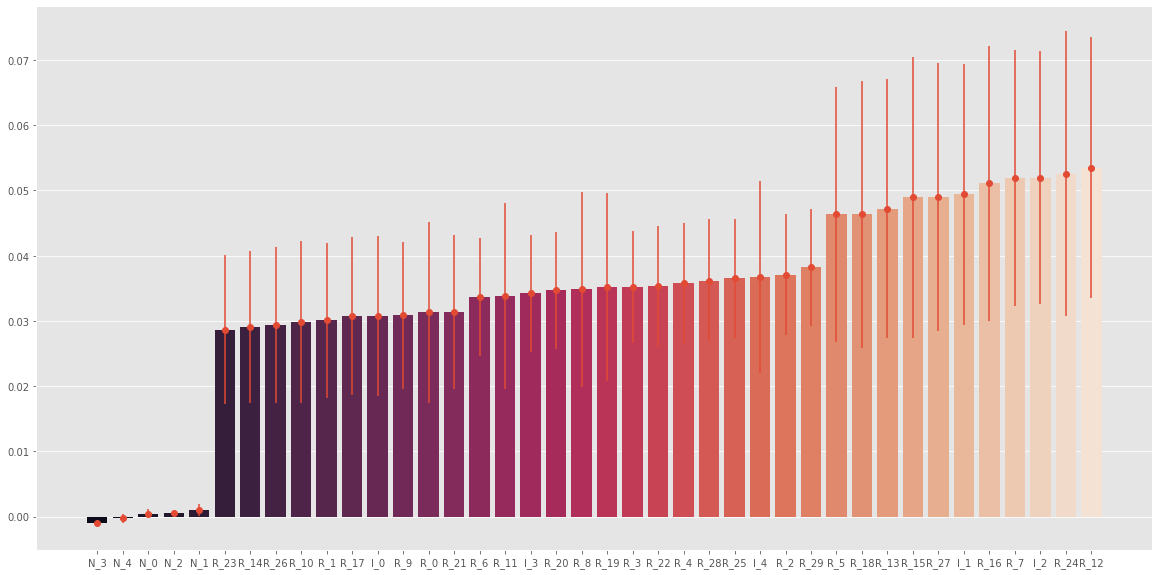

In [23]:
# MDA
clf = DecisionTreeClassifier(
    criterion='entropy', max_features=1,
    class_weight='balanced', min_weight_fraction_leaf=0
)
clf = BaggingClassifier(
    base_estimator=clf, n_estimators=1000, max_features=1.,
    max_samples=1., oob_score=False
)

imp=feat_imp_mda(clf,X,y,10).sort_values(by=['mean'])

ax = sns.barplot(x=imp.index, y=imp['mean'].values, palette="rocket")
ax.errorbar(imp.index, imp['mean'], yerr=imp['std'], ls='none', fmt='-o')

We can see that the
- For MDI and MDA, we don't see many differences compared to the initial setup
- I would have expected the features importance to have a piecewise form  